In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re  
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import FreqDist?

nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



Object `FreqDist` not found.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/williamsa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('../data/judge_1377884607_tweet_product_company.csv')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.rename(columns = {"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace = True)

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

In [7]:
df = df.drop(df[df['emotion'] == "I can't tell"].index)

In [8]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
Name: emotion, dtype: int64

In [9]:
df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [10]:
df.dropna(inplace = True)

In [11]:
df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [12]:
# the following code is courtesy of Dr. Praveen Gowtham
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    stop_words += ['rt', 'link']

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return tweet_norm.split(" ")

In [13]:
df['tweet_tokens'] = df['tweet_text'].apply(process_tweet, args = [5])

In [14]:
df = df.drop(df[df['tweet_tokens'] == ""].index)

In [15]:
df

,tweet_text,emotion,tweet_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[iphone, hr, tweet, dead, need, upgrade, plugi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[know, awesome, app, likely, appreciate, desig..."
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[great, stuff, fri, mayer, google, tim, tech, ..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product,"[new, ipad, apps, communication, showcased, co..."
...,...,...,...
8714,Google says: want to give a lightning talk to ...,No emotion toward brand or product,"[google, say, want, give, lightning, talk, aud..."
8715,"@mention Yup, but I don't have a third app yet...",No emotion toward brand or product,"[yup, third, app, yet, android, suggestion, cc]"
8717,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,"[wave, buzz, interrupt, regularly, schedule, g..."
8718,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,"[google, zeiger, physician, never, report, pot..."


In [16]:
df['emotion']

0                         Negative emotion
1                         Positive emotion
3                         Negative emotion
4                         Positive emotion
5       No emotion toward brand or product
                       ...                
8714    No emotion toward brand or product
8715    No emotion toward brand or product
8717    No emotion toward brand or product
8718    No emotion toward brand or product
8719    No emotion toward brand or product
Name: emotion, Length: 6999, dtype: object

In [17]:
labelencoder = LabelEncoder()

df['sentiment'] =  labelencoder.fit_transform(df['emotion'])

df

,tweet_text,emotion,tweet_tokens,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[iphone, hr, tweet, dead, need, upgrade, plugi...",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[know, awesome, app, likely, appreciate, desig...",2
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[great, stuff, fri, mayer, google, tim, tech, ...",2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product,"[new, ipad, apps, communication, showcased, co...",1
...,...,...,...,...
8714,Google says: want to give a lightning talk to ...,No emotion toward brand or product,"[google, say, want, give, lightning, talk, aud...",1
8715,"@mention Yup, but I don't have a third app yet...",No emotion toward brand or product,"[yup, third, app, yet, android, suggestion, cc]",1
8717,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,"[wave, buzz, interrupt, regularly, schedule, g...",1
8718,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,"[google, zeiger, physician, never, report, pot...",1


In [18]:
processed_df = df[['tweet_tokens', 'sentiment']]

In [19]:
processed_df

,tweet_tokens,sentiment
0,"[iphone, hr, tweet, dead, need, upgrade, plugi...",0
1,"[know, awesome, app, likely, appreciate, desig...",2
3,"[hope, year, festival, crashy, year, iphone, app]",0
4,"[great, stuff, fri, mayer, google, tim, tech, ...",2
5,"[new, ipad, apps, communication, showcased, co...",1
...,...,...
8714,"[google, say, want, give, lightning, talk, aud...",1
8715,"[yup, third, app, yet, android, suggestion, cc]",1
8717,"[wave, buzz, interrupt, regularly, schedule, g...",1
8718,"[google, zeiger, physician, never, report, pot...",1


In [20]:
#This is an extremely important cell that must remain in the final version
la_vaca = 'mooo'

In [21]:
processed_df

,tweet_tokens,sentiment
0,"[iphone, hr, tweet, dead, need, upgrade, plugi...",0
1,"[know, awesome, app, likely, appreciate, desig...",2
3,"[hope, year, festival, crashy, year, iphone, app]",0
4,"[great, stuff, fri, mayer, google, tim, tech, ...",2
5,"[new, ipad, apps, communication, showcased, co...",1
...,...,...
8714,"[google, say, want, give, lightning, talk, aud...",1
8715,"[yup, third, app, yet, android, suggestion, cc]",1
8717,"[wave, buzz, interrupt, regularly, schedule, g...",1
8718,"[google, zeiger, physician, never, report, pot...",1


In [22]:
all_tokens = []

for row in processed_df['tweet_tokens']:
    for token in row:
        all_tokens.append(token)

freq_dist = FreqDist(all_tokens)

freq_dist.most_common(10)

NameError: name 'FreqDist' is not defined

[('google', 1944),
 ('ipad', 1787),
 ('apple', 1543),
 ('quot', 1535),
 ('store', 1211),
 ('iphone', 1032),
 ('new', 1016),
 ('launch', 743),
 ('austin', 739),
 ('amp', 696)]

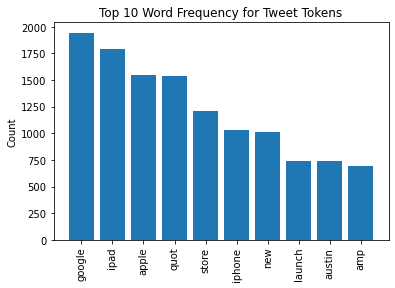

In [ ]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(freq_dist, "Top 10 Word Frequency for Tweet Tokens")

In [ ]:
processed_df['string_tokens'] = processed_df['tweet_tokens'].apply(" ".join)

/var/folders/q_/g2zssbt10h1blxnpvcp374lw0000gn/T/ipykernel_58612/357343184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['string_tokens'] = processed_df['tweet_tokens'].apply(" ".join)


In [ ]:
pd.to_pickle(processed_df, './processed_df.pkl')

In [ ]:
X = processed_df['string_tokens']
y = processed_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
vectorizer = TfidfVectorizer(min_df= 0.05, max_df = 0.95)

X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

In [ ]:
# from nltk import ngrams

# processed_df['ngrams'] = processed_df['string_tokens'].apply(lambda x: ngrams(x.split(), 2))

In [ ]:
processed_df

,tweet_tokens,sentiment,string_tokens
0,"[iphone, hr, tweet, dead, need, upgrade, plugi...",0,iphone hr tweet dead need upgrade plugin station
1,"[know, awesome, app, likely, appreciate, desig...",2,know awesome app likely appreciate design also...
3,"[hope, year, festival, crashy, year, iphone, app]",0,hope year festival crashy year iphone app
4,"[great, stuff, fri, mayer, google, tim, tech, ...",2,great stuff fri mayer google tim tech amp matt...
5,"[new, ipad, apps, communication, showcased, co...",1,new ipad apps communication showcased conference
...,...,...,...
8714,"[google, say, want, give, lightning, talk, aud...",1,google say want give lightning talk audience t...
8715,"[yup, third, app, yet, android, suggestion, cc]",1,yup third app yet android suggestion cc
8717,"[wave, buzz, interrupt, regularly, schedule, g...",1,wave buzz interrupt regularly schedule geek pr...
8718,"[google, zeiger, physician, never, report, pot...",1,google zeiger physician never report potential...


In [ ]:
pos_df = processed_df[processed_df['sentiment'] == 2]

neg_df = processed_df[processed_df['sentiment'] == 0]

In [ ]:
pos_tokens = []

for row in pos_df['tweet_tokens']:
    for token in row:
        pos_tokens.append(token)

pos_freq_dist = FreqDist(pos_tokens)

pos_freq_dist.most_common(10)

[('ipad', 750),
 ('apple', 651),
 ('google', 575),
 ('store', 492),
 ('quot', 447),
 ('iphone', 370),
 ('new', 333),
 ('app', 321),
 ('get', 265),
 ('austin', 234)]

In [ ]:
neg_tokens = []

for row in neg_df['tweet_tokens']:
    for token in row:
        neg_tokens.append(token)

neg_freq_dist = FreqDist(neg_tokens)

neg_freq_dist.most_common(10)

[('quot', 165),
 ('ipad', 149),
 ('iphone', 126),
 ('google', 118),
 ('apple', 90),
 ('app', 48),
 ('new', 43),
 ('get', 39),
 ('store', 38),
 ('need', 35)]